# Analysing Glassdoor Reviews: Impact of Job Satisfaction on Employee Retention and Firm Performance in the IT Industry

The goal here is to create a **linear regression model** to help with the titular objective. We want to determine the impact of **job satisfaction** on:
1. **Employee retention**, and
2. **Firm performance**,
3. within the **IT industry** only.

Our data sources are **Glassdoor**, **Yahoo Finance** for retrieving measures of firm financial performance, and a **Ticker** dataset to match company names with their tickers, ensuring that financial data can be retrieved for the companies reviewed on Glassdoor. 

To achieve our goal, we'll follow these steps:
1. Scrape Glassdoor reviews
2. Clean Glassdoor data
3. Retrieve tickers of the **top public IT firms**, effectively restricting the scope to only companies within the IT Industry, and only those with publicly available financial data
4. Clean ticker data
5. Merge datasets
6. Extract employee retention data from Glassdoor review data
7. Retrieve financial performance data
8. Convert data to numerical values where possible, and prepare final database for input to the linear regression model
9. Run the linear regression model and determine coefficients


# ~~~~~~~~~~
### An issue I'm realising here. Do we even need a linear regression at all? Like the reason you'd want to use a linear regression would be to understand the coefficient of each input to the regression in predicting the output.
### I.e. in this case it would help us to understand if the overall rating of the Glassdoor review is the biggest predictor of employee retention and financial performance WHEN COMPARED TO all the other inputs, e.g. 0.95 x review_rating + 0.01 x CEO approval + .... = EBITDA
### What you ACTUALLY want is a correlation coefficient, isn't it?
### The difficulty comes in figuring out how to calculate correlation between a tonne of input variables and two output variables.
### All that being said, the linear regression would for sure bring some interesting analysis anyway, so it's definitely worth exploring. E.g. you'd be able to say whether good/bad management has a big impact on employee retention / firm performance, as opposed to good/bad culture & values for example.


### Yeah, pretty sure we're definitely looking for a correlation coefficient as opposed to anything else. Let's see what other literature does...

### Interestingly enough, I think regression analysis is actually more than enough. Looking at other papers, they commonly use OLS regression analysis, which seems to be a great way to measure both overall correlation as well as the coefficients of each variable. Using that, you could draw plenty of analysis about what specific aspects of job satisfaction have the biggest impact, as well as create a model to predict the future performance of a company right now.

### Another thing I'm just considering right now is that I'm gonna have to consider how I bring in the variable of date/time here. Like do I limit the review data to only the reviews in the past year?
### It's actually a pretty significant choice and I reckon other literature kinda just glosses over it. Like there's also the idea of do you choose reviews from Q2 and compare with performance in Q3? Or performance in Q2? Or performance in Q4? Idk. Could theoretically compare all three to see which correlates the most overall, then do an in-depth analysis of the most correlated quarters.

### Looks like a good idea is to separate by quarters. Probably don't discuss it too much.
### Also, yfinance has a limitation of returning financial data for the last 4 years or last 5 quarters, regardless of start date.

### 0. Glassdoor review scraping <br /> 1. Glassdoor data cleaning <br /> 2. Exploratory data analysis on Glassdoor reviews <br /> 3. Retrieve Yahoo Finance data on company financials <br /> 4. Exploratory data analysis on Yahoo financials <br /> 5. Data cleaning on both Glassdoor reviews and Yahoo financials <br /> 6. Combine datasets <br /> 

Glassdoor reviews have been pre-scraped using selenium chromedriver. Here's an example of what we're scraping:

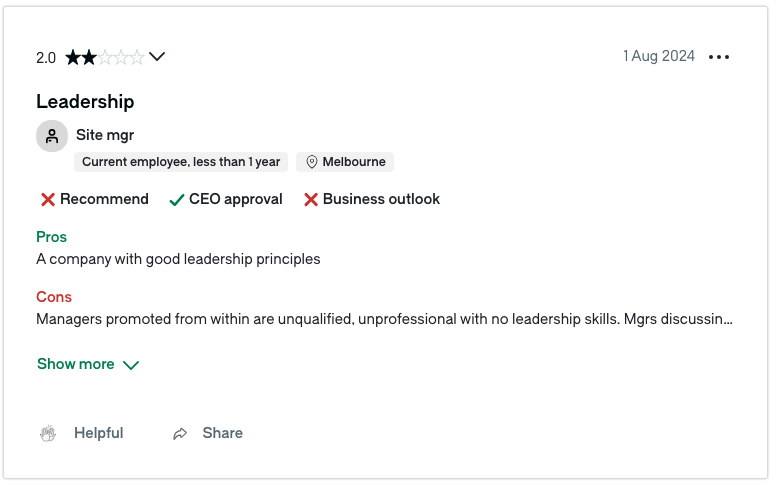

So, we might expect the following columns:
- overall rating
- title
- employee status
- recommend
- CEO approval
- business outlook
- pros
- cons
- date

and of course **company**. On top of that, each review also comes with category ratings:

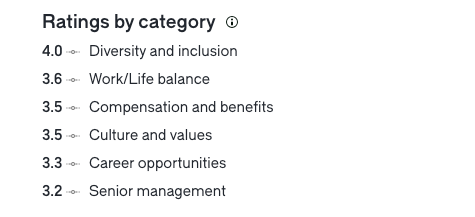

So we can expect those columns too. 

With the scraping complete, let's move to data inspection and cleaning.

## Step 1: Glassdoor Data Cleaning

First let's get a preview of the data.

In [59]:
import numpy as np
import pandas as pd

df = pd.read_csv('all-reviews.csv', low_memory=False)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9901889 entries, 0 to 9901888
Data columns (total 19 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   rating                     float64
 1   title                      object 
 2   status                     object 
 3   pros                       object 
 4   cons                       object 
 5   advice                     object 
 6   Recommend                  object 
 7   CEO Approval               object 
 8   Business Outlook           object 
 9   Career Opportunities       object 
 10  Compensation and Benefits  object 
 11  Senior Management          object 
 12  Work/Life Balance          object 
 13  Culture & Values           float64
 14  Diversity & Inclusion      float64
 15  firm_link                  object 
 16  date                       object 
 17  job                        object 
 18  index                      float64
dtypes: float64(4), object(15)
memory usage: 1.

Nice. So we have **9,901,889** rows, 19 columns, and all the expected columns from the images above. Let's have a look at the data itself.

In [60]:
df.head(2)

,rating,title,status,pros,cons,advice,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,firm_link,date,job,index
0,5.0,Good,"Current Employee, more than 10 years",Knowledge gain of complete project,Financial growth and personal growth,NaN,v,o,v,3,3,3,3,3.0,3.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Nov 19, 2022",Manager Design,NaN
1,4.0,Good,"Former Employee, less than 1 year","Good work,good work , flexible, support","Good,work, flexible,good support, good team work",NaN,v,o,o,4,4,4,4,4.0,4.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Jan 29, 2022",Anonymous Employee,NaN


Looks good. Things to note here:
- there's clearly some null data
- firm link doesn't actually contain the company, just some sort of URL
- the columns (Recommend, CEO Approval, Business Outlook) are represented by letters.

This was done purposefully while scraping. The company name will need to be extracted from the firm link, while the letter ratings are as follows:
- **v = Positive**
- **r = Mild**
- **x = Negative**
- **o = No opinion**

To actually work with these, we'll need to decide how to convert these accurately to a numerical scale later on.

For now, let's start cleaning the data.

In [2]:
print(df.isnull().sum())

rating                           171
title                          39424
status                           171
pros                             188
cons                             234
advice                       9901876
Recommend                        171
CEO Approval                     171
Business Outlook                 171
Career Opportunities         1848262
Compensation and Benefits    1878091
Senior Management            1975466
Work/Life Balance            1894490
Culture & Values             2246773
Diversity & Inclusion        6544282
firm_link                          0
date                             171
job                              171
index                        9740269
dtype: int64


Clearly there is a lot of missing data, so we have to decide what to do with it.

There are **9901889 rows**, and the **'advice'** column is missing almost all of these, so we can drop that. 

Now, it looks like **Diversity & Inclusion** is missing more than half the rows, so it was probably introduced recently. Seeing as we have all the other measures, it won't impact our models too much if we drop it, and besides, it isn't a great measure of job satisfaction.

The **index** column seems to be unnecessary, so that can be dropped too.

In [3]:
df.drop(columns=['advice','index','Diversity & Inclusion'], inplace=True)

Great. With that done, we shouldn't need to remove any more columns. From here, we need to decide how to deal with the remaining missing values. The simplest solution will probably be to just remove all rows with missing values. Let's try that.

In [4]:
df.describe(include='all')

,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm_link,date,job
count,9.901718e+06,9862465,9901718,9901701,9901655,9901718,9901718,9901718,8053627,8023798,7926423,8007399,7.655116e+06,9901889,9901718,9901718
unique,NaN,3589503,95,8399148,8428752,3,4,4,14,14,14,14,NaN,35541,5612,440593
top,NaN,Good,Current Employee,Great company to work for,None that I can think of,v,o,o,4,4,3,5,NaN,Reviews/Walmart-Reviews-E395425.htm,"Jan 11, 2021",Anonymous Employee
freq,NaN,193318,2328379,8301,13496,4613452,3806071,3526619,1773632,1930462,1605600,1824377,NaN,64064,11138,1704869
mean,3.557778e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.481324e+00,NaN,NaN,NaN
std,1.249354e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.389978e+00,NaN,NaN,NaN
min,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN
25%,3.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00,NaN,NaN,NaN
50%,4.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e+00,NaN,NaN,NaN
75%,5.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e+00,NaN,NaN,NaN


In [5]:
cleaned_df = df.dropna()

In [6]:
print(cleaned_df.isnull().sum())
print(cleaned_df.info())
cleaned_df.head(10)

rating                       0
title                        0
status                       0
pros                         0
cons                         0
Recommend                    0
CEO Approval                 0
Business Outlook             0
Career Opportunities         0
Compensation and Benefits    0
Senior Management            0
Work/Life Balance            0
Culture & Values             0
firm_link                    0
date                         0
job                          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 7488389 entries, 0 to 9901888
Data columns (total 16 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   rating                     float64
 1   title                      object 
 2   status                     object 
 3   pros                       object 
 4   cons                       object 
 5   Recommend                  object 
 6   CEO Approval               object 
 7   Business Outlook  

,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm_link,date,job
0,5.0,Good,"Current Employee, more than 10 years",Knowledge gain of complete project,Financial growth and personal growth,v,o,v,3,3,3,3,3.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Nov 19, 2022",Manager Design
1,4.0,Good,"Former Employee, less than 1 year","Good work,good work , flexible, support","Good,work, flexible,good support, good team work",v,o,o,4,4,4,4,4.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Jan 29, 2022",Anonymous Employee
2,4.0,"Supervising the manufacturing the processes, e...","Current Employee, more than 1 year",This company is a best opportunity for me to l...,"Monthly Target work,Maintain production schedu...",v,o,v,2,3,2,2,2.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Aug 12, 2021",Production Engineer
3,1.0,terrible,"Current Employee, more than 1 year",I wish there were some to list,too many to list here,x,x,x,1.0,3.0,1.0,3.0,1.0,https://www.glassdoor.com/Reviews/Calgary-Flam...,"Sep 24, 2020",Senior Account Executive
4,4.0,"It could be so good, but it isn’t","Current Employee, more than 3 years",Fast Paced. Endless challenges. Inclusive envi...,The biggest perk of the job provides no value ...,o,o,o,3.0,3.0,3.0,1.0,4.0,https://www.glassdoor.com/Reviews/Calgary-Flam...,"Mar 25, 2023",Assistant Manager
5,3.0,Good enough,"Former Employee, more than 5 years","Discounts, benefits, life long friends.","Drama, playing favorites, low pay",x,r,r,2.0,2.0,2.0,2.0,2.0,https://www.glassdoor.com/Reviews/Calgary-Flam...,"Apr 6, 2023",Floor Supervisor
6,1.0,Don’t trust HR and that provide you the tools ...,"Former Employee, less than 1 year","Pay was not bad, tickets were nice if your fan...",Never have I worked in such toxic environment ...,x,x,x,1.0,1.0,1.0,2.0,1.0,https://www.glassdoor.com/Reviews/Calgary-Flam...,"Oct 29, 2022",Anonymous Employee
9,3.0,Good job for part timers,"Former Employee, more than 1 year",Watch games for free depending where you are s...,"Pay is minimum wage, no pay raises,",x,x,x,1.0,1.0,1.0,3.0,1.0,https://www.glassdoor.com/Reviews/Calgary-Flam...,"Aug 17, 2022",Security Guard
10,4.0,Fun Experience,Current Employee,"Great energy, caring co-workers and , rewarding.",You just get put into the action so be ready f...,v,r,v,4.0,2.0,4.0,3.0,5.0,https://www.glassdoor.com/Reviews/Calgary-Flam...,"Jul 27, 2022",Anonymous Employee
11,3.0,Somewhat Good Experience,"Former Employee, more than 8 years",Worked with some great people.,The Management in Ushering shows favoritism.,x,r,r,1.0,1.0,1.0,4.0,3.0,https://www.glassdoor.com/Reviews/Calgary-Flam...,"Jun 14, 2022",Usher/Ticket Taker


Great, we now have **7.4M+** rows of complete data. Our next job is to convert as many columns to numerical data as possible. Now, the following columns should all theoretically be an integer rating of **1 to 5**: Career Opportunities, Compensation and Benefits, Senior Management, Work/Life Balance, Culture & Values.

For some reason, only Culture & Values is listed as a float object. Let's try and figure out why the other's aren't numerical.

In [7]:
cult_values = cleaned_df['Culture & Values'].value_counts().sort_values(ascending=False)
cult_values

Culture & Values
5.0    2347151
4.0    1809577
3.0    1468169
1.0    1041767
2.0     821725
Name: count, dtype: int64

In [8]:
career_opportunities = cleaned_df['Career Opportunities'].value_counts().sort_values(ascending=False)
career_opportunities

Career Opportunities
4      1667688
5      1618273
3      1614002
2       873929
1       821453
5.0     241114
4.0     197973
3.0     190856
1.0     144524
2.0     118577
Name: count, dtype: int64

In [9]:
comp_benefits = cleaned_df['Compensation and Benefits'].value_counts().sort_values(ascending=False)
comp_benefits

Compensation and Benefits
4      1823072
3      1763516
5      1499640
2       904171
1       707858
4.0     201082
5.0     188945
3.0     188662
2.0     106288
1.0     105155
Name: count, dtype: int64

In [10]:
senior_mgmt = cleaned_df['Senior Management'].value_counts().sort_values(ascending=False)
senior_mgmt

Senior Management
3      1519595
4      1496143
5      1321921
1      1255587
2       941843
5.0     238807
1.0     213381
4.0     200227
3.0     180917
2.0     119968
Name: count, dtype: int64

In [11]:
wl_balance = cleaned_df['Work/Life Balance'].value_counts().sort_values(ascending=False)
wl_balance

Work/Life Balance
5      1725979
4      1634957
3      1548700
1       923355
2       834443
5.0     244547
4.0     189566
3.0     169049
1.0     125706
2.0      92087
Name: count, dtype: int64

So, looks like we need to reformulate some integers as **floats**.

In [12]:
for col in ['Career Opportunities','Compensation and Benefits','Senior Management','Work/Life Balance']:
    cleaned_df[col] = cleaned_df[col].astype(float)

/var/folders/zd/42hpy_6973sb371vptm8blwh0000gn/T/ipykernel_85974/2119151627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[col] = cleaned_df[col].astype(float)
/var/folders/zd/42hpy_6973sb371vptm8blwh0000gn/T/ipykernel_85974/2119151627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[col] = cleaned_df[col].astype(float)
/var/folders/zd/42hpy_6973sb371vptm8blwh0000gn/T/ipykernel_85974/2119151627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [13]:
print(cleaned_df.info())
cleaned_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Index: 7488389 entries, 0 to 9901888
Data columns (total 16 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   rating                     float64
 1   title                      object 
 2   status                     object 
 3   pros                       object 
 4   cons                       object 
 5   Recommend                  object 
 6   CEO Approval               object 
 7   Business Outlook           object 
 8   Career Opportunities       float64
 9   Compensation and Benefits  float64
 10  Senior Management          float64
 11  Work/Life Balance          float64
 12  Culture & Values           float64
 13  firm_link                  object 
 14  date                       object 
 15  job                        object 
dtypes: float64(6), object(10)
memory usage: 971.2+ MB
None


,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm_link,date,job
count,7.488389e+06,7488389,7488389,7488389,7488389,7488389,7488389,7488389,7.488389e+06,7.488389e+06,7.488389e+06,7.488389e+06,7.488389e+06,7488389,7488389,7488389
unique,NaN,2926533,88,6459062,6465240,3,4,4,NaN,NaN,NaN,NaN,NaN,32833,4072,383958
top,NaN,Good,Current Employee,Great company to work for,None that I can think of,v,v,v,NaN,NaN,NaN,NaN,NaN,Reviews/Walmart-Reviews-E395425.htm,"Sep 14, 2020",Anonymous Employee
freq,NaN,114397,1291717,4912,8667,4241217,2951250,3267048,NaN,NaN,NaN,NaN,NaN,45456,8492,1271231
mean,3.530581e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.355213e+00,3.369217e+00,3.109246e+00,3.366023e+00,3.480560e+00,NaN,NaN,NaN
std,1.271618e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.328420e+00,1.266955e+00,1.405253e+00,1.358803e+00,1.389486e+00,NaN,NaN,NaN
min,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN
25%,3.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+00,3.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,NaN,NaN,NaN
50%,4.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,NaN,NaN,NaN
75%,5.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,NaN,NaN,NaN


In [120]:
from datetime import datetime

dates = cleaned_df['date'].copy()


dates = dates.apply(lambda x: datetime.strptime(str(x).strip(' '), '%b %d, %Y'))

sorted_dates = dates.sort_values()

In [136]:
sorted_dates

4108992   2012-05-22
7495730   2012-05-22
9427497   2012-05-22
9855201   2012-05-22
6902927   2012-05-22
             ...    
5062703   2023-07-15
749242    2023-07-18
5062702   2023-07-18
2215195   2023-07-20
4126542   2023-07-26
Name: date, Length: 7488389, dtype: datetime64[ns]

**Idea**: v = 1, r = 0, x = -1, o = 0?

Lots more do to after this, but a couple things to remember:
- convert status of employee to employee retention somehow

### Converting firm_link to Company Name

In [15]:
import re
import urllib.parse

print(cleaned_df.firm_link[1])
print(cleaned_df.firm_link[469])
print(cleaned_df.firm_link[1901])
print(cleaned_df.firm_link[5901])
print(cleaned_df.firm_link[99802])

Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm
https://www.glassdoor.com/Reviews/Canada-Life-Reviews-E23636.htm
Reviews/SS&C-Advent-Reviews-E646079.htm
https://www.glassdoor.com/Reviews/Boston-Red-Sox-Reviews-E5205.htm
Reviews/Chipotle-Reviews-E1370610.htm


In [16]:
for index, firm_link in cleaned_df.firm_link.items():
    if "%" in firm_link:
        print(firm_link)
        print(index)
        break

https://www.glassdoor.com/Reviews/Universit%C3%A9-Toulouse-III-Paul-Sabatier-Reviews-E753896.htm
135445


An issue here that needs fixing - the url parser has returned unusual utf-8 characters for special characters such as accents. Let's fix that:

In [17]:
parsed_firms = cleaned_df.firm_link.copy()

ctr = 0
for index, firm_link in parsed_firms.items():
    if "%" in firm_link:
        parsed_firms.loc[index] = urllib.parse.unquote(firm_link)

cleaned_df['firm_link'] = parsed_firms

/var/folders/zd/42hpy_6973sb371vptm8blwh0000gn/T/ipykernel_85974/2750734841.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['firm_link'] = parsed_firms


In [18]:
print(cleaned_df.firm_link.loc[135445])

https://www.glassdoor.com/Reviews/Université-Toulouse-III-Paul-Sabatier-Reviews-E753896.htm


Looks like we've fixed it.
Now, as we can see here and above, we can extract the company name from the firm link data. We just need the part after 'Reviews/', and before '-Reviews'.

In [19]:
firm_attempt = cleaned_df['firm_link'].str.extract(r'(?<=Reviews\/)(.*)(?=-Reviews)')

In [20]:
firm_attempt.shape

(7488389, 1)

In [21]:
print(firm_attempt[0].nunique())
print(firm_attempt[0].value_counts())

31750
0
Amazon                            121747
Tata-Consultancy-Services          82564
Walmart                            72982
Cognizant-Technology-Solutions     64066
Accenture                          56224
                                   ...  
Tailored-Freight-Solutions             1
Makefied-Dental-Associates             1
Imax-Pro                               1
Gone-Outdoor-Supply                    1
Focus-Otsego                           1
Name: count, Length: 31750, dtype: int64


In [22]:
firms = pd.unique(firm_attempt[0].sort_values(ascending=True))

In [23]:
for firm in firms:
    if 'Review' in firm:
        print(firm)

print("~~~~~~~~")
        
for firm in firms:
    if 'Advanced-Medical' in firm:
        print(firm)

Advanced-Medical-Reviews
Global-Trade-Review
Physicians'-Review-Network
The-Princeton-Review
TimesReview-NewsGroup
~~~~~~~~
Advanced-Medical-Reviews
Advanced-Medical-of-Nashville


I'm checking here to make sure that the regex hasn't doubled up any company names, e.g. Advanced-Medical-Reviews might have returned as both Advanced-Medical-Reviews and Advanced-Medical, thanks to the regex.

But that hasn't happened, so looks like our regex worked successfully. So, let's apply it to the main dataframe. 

In [24]:
cleaned_df = cleaned_df.rename(columns={'firm_link':'firm'})
cleaned_df['firm'] = cleaned_df['firm'].str.extract(r'(?<=Reviews\/)(.*)(?=-Reviews)')
cleaned_df['firm'] = cleaned_df['firm'].str.replace('-',' ', regex=False)
cleaned_df.head(5)

,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm,date,job
0,5.0,Good,"Current Employee, more than 10 years",Knowledge gain of complete project,Financial growth and personal growth,v,o,v,3.0,3.0,3.0,3.0,3.0,Baja Steel and Fence,"Nov 19, 2022",Manager Design
1,4.0,Good,"Former Employee, less than 1 year","Good work,good work , flexible, support","Good,work, flexible,good support, good team work",v,o,o,4.0,4.0,4.0,4.0,4.0,Baja Steel and Fence,"Jan 29, 2022",Anonymous Employee
2,4.0,"Supervising the manufacturing the processes, e...","Current Employee, more than 1 year",This company is a best opportunity for me to l...,"Monthly Target work,Maintain production schedu...",v,o,v,2.0,3.0,2.0,2.0,2.0,Baja Steel and Fence,"Aug 12, 2021",Production Engineer
3,1.0,terrible,"Current Employee, more than 1 year",I wish there were some to list,too many to list here,x,x,x,1.0,3.0,1.0,3.0,1.0,Calgary Flames,"Sep 24, 2020",Senior Account Executive
4,4.0,"It could be so good, but it isn’t","Current Employee, more than 3 years",Fast Paced. Endless challenges. Inclusive envi...,The biggest perk of the job provides no value ...,o,o,o,3.0,3.0,3.0,1.0,4.0,Calgary Flames,"Mar 25, 2023",Assistant Manager


In [25]:
print(cleaned_df.head(5))

   rating                                              title  \
0     5.0                                               Good   
1     4.0                                               Good   
2     4.0  Supervising the manufacturing the processes, e...   
3     1.0                                           terrible   
4     4.0                  It could be so good, but it isn’t   

                                 status  \
0  Current Employee, more than 10 years   
1     Former Employee, less than 1 year   
2    Current Employee, more than 1 year   
3    Current Employee, more than 1 year   
4   Current Employee, more than 3 years   

                                                pros  \
0                Knowledge gain of complete  project   
1            Good work,good work , flexible, support   
2  This company is a best opportunity for me to l...   
3                     I wish there were some to list   
4  Fast Paced. Endless challenges. Inclusive envi...   

                   

## Step 2: Exploratory Glassdoor Data Analysis

In [26]:
cleaned_df.describe(include='all')

,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm,date,job
count,7.488389e+06,7488389,7488389,7488389,7488389,7488389,7488389,7488389,7.488389e+06,7.488389e+06,7.488389e+06,7.488389e+06,7.488389e+06,7488389,7488389,7488389
unique,NaN,2926533,88,6459062,6465240,3,4,4,NaN,NaN,NaN,NaN,NaN,31750,4072,383958
top,NaN,Good,Current Employee,Great company to work for,None that I can think of,v,v,v,NaN,NaN,NaN,NaN,NaN,Amazon,"Sep 14, 2020",Anonymous Employee
freq,NaN,114397,1291717,4912,8667,4241217,2951250,3267048,NaN,NaN,NaN,NaN,NaN,121747,8492,1271231
mean,3.530581e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.355213e+00,3.369217e+00,3.109246e+00,3.366023e+00,3.480560e+00,NaN,NaN,NaN
std,1.271618e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.328420e+00,1.266955e+00,1.405253e+00,1.358803e+00,1.389486e+00,NaN,NaN,NaN
min,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN
25%,3.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+00,3.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,NaN,NaN,NaN
50%,4.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,NaN,NaN,NaN
75%,5.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,NaN,NaN,NaN


## Step 2: Add tickers to Glassdoor dataset and reduce to top public tech companies

Our next step here is to add Tickers to the according company names in our dataset. This will allow us to easily fetch financial data for each company. In this step, we'll also be significantly reducing our dataset to only match companies that we can find a Ticker for. This will mean only public companies can be examined, and furthermore we will only look at the top ~500 IT companies since they will have much more complete data to work with.

A good way to match Ticker to company name will be with some sort of fuzzy match / cosine similarity score.

In [27]:
tech_firm_tickers_df = pd.read_csv('tech-firms-by-market-cap.csv')
tech_firm_tickers_df.head(10)

,Rank,Name,Symbol,marketcap,price (USD),country
0,1,Microsoft,MSFT,3.073560e+12,413.54,United States
1,2,Apple,AAPL,2.786360e+12,181.71,United States
2,3,NVIDIA,NVDA,2.303500e+12,921.40,United States
3,4,Alphabet (Google),GOOG,2.086900e+12,169.83,United States
4,5,Amazon,AMZN,1.963730e+12,188.70,United States
5,6,Meta Platforms (Facebook),META,1.181210e+12,465.68,United States
6,7,TSMC,TSM,7.408610e+11,142.83,Taiwan
7,8,Broadcom,AVGO,6.072250e+11,1310.31,United States
8,9,Tesla,TSLA,5.892370e+11,184.76,United States
9,10,Tencent,TCEHY,4.465780e+11,47.41,China


In [28]:
print(tech_firm_tickers_df.shape)

(952, 6)


In [29]:
glassdoor_companies = pd.DataFrame(cleaned_df['firm'].unique(), columns=['Firm'])
print(glassdoor_companies.shape)

(31750, 1)


All this setup is to prepare for matching. First we attempt basic equality matching, then compare this with far more advanced name matching.

In [30]:
ctr = 0
for company1 in tech_firm_tickers_df['Name']:
    for company2 in glassdoor_companies['Firm']:
        if company1.lower() == company2.lower():
            ctr += 1
            break
print("%s matches on equality." % ctr)

211 matches on equality.


In [31]:
from name_matching.name_matcher import NameMatcher

matcher = NameMatcher(top_n=500,
    number_of_rows=31750,
    lowercase=True,
    punctuations=True,
    remove_ascii=True,
    legal_suffixes=False,
    common_words=True,
    verbose=True)

In [32]:
matcher.load_and_process_master_data('Firm', glassdoor_companies)
matches = matcher.match_names(to_be_matched=tech_firm_tickers_df, column_matching='Name')

preprocessing...

preprocessing complete 
 searching for matches...



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


possible matches found   
 fuzzy matching...



100%|█████████████████████████████████████████| 952/952 [05:15<00:00,  3.02it/s]

done


In [33]:
print(matches.shape)
print((matches['score'] == 0.0).sum().sum())
print((matches['score'] == 100.0).sum().sum())
print((matches['score'] >= 75.0).sum().sum())
print(matches.isnull().sum())

(952, 4)
71
237
350
original_name    0
match_name       0
score            0
match_index      0
dtype: int64


In [34]:
matches.to_csv('matches.csv', index=False)

Given that the matching was fairly successful but there are still many, many edge cases, the best option is simply to go through all the matches manually. I have exported these matches to an external csv and updated them in a new file, 'matches-updated.csv'.

In [35]:
companies = cleaned_df['firm'].copy()
comp_counts = companies.value_counts()
comp_pcts = companies.value_counts(normalize=True)

checks = ['sohu']


for company, count in comp_counts.items():
    for check in checks:
        if check in company.lower() and count > 50:
            print("{} reviews, {:.2f}%: {}".format(count, comp_pcts[company]*100, company))

In [36]:
matches_updated = pd.read_csv('matches-updated.csv', low_memory=False)
print(matches_updated.shape)
print(matches_updated.isnull().sum())

(967, 2)
match_name    649
Symbol          1
dtype: int64


In [37]:
matches_updated = matches_updated.dropna()
print(matches_updated.shape)
print(matches_updated.head(1))

(318, 2)
  match_name Symbol
0  microsoft   MSFT


We now have a list of 318 companies and tickers. The next step is to merge our entire glassdoor dataset into this dataframe. First I'll refactor the ticker dataset to look a little nicer.

In [38]:
tickers_df = matches_updated.rename(columns={"match_name": "firm", "Symbol": "Ticker"})
tickers_df = tickers_df.reset_index().drop(['index'], axis=1)
# tickers_df['Name'] = tickers_df['Name'].apply(lambda x: x.title())
tickers_df

,firm,Ticker
0,microsoft,MSFT
1,apple,AAPL
2,nvidia,NVDA
3,google,GOOG
4,amazon,AMZN
...,...,...
313,zensar technologies,ZENSARTECH.NS
314,kpit technologies,KPITTECH.NS
315,accenture,ACN
316,infosys,INFY.NS


In [39]:
cleaned_df['firm'] = cleaned_df['firm'].apply(lambda x: x.lower())
cleaned_df

,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm,date,job
0,5.0,Good,"Current Employee, more than 10 years",Knowledge gain of complete project,Financial growth and personal growth,v,o,v,3.0,3.0,3.0,3.0,3.0,baja steel and fence,"Nov 19, 2022",Manager Design
1,4.0,Good,"Former Employee, less than 1 year","Good work,good work , flexible, support","Good,work, flexible,good support, good team work",v,o,o,4.0,4.0,4.0,4.0,4.0,baja steel and fence,"Jan 29, 2022",Anonymous Employee
2,4.0,"Supervising the manufacturing the processes, e...","Current Employee, more than 1 year",This company is a best opportunity for me to l...,"Monthly Target work,Maintain production schedu...",v,o,v,2.0,3.0,2.0,2.0,2.0,baja steel and fence,"Aug 12, 2021",Production Engineer
3,1.0,terrible,"Current Employee, more than 1 year",I wish there were some to list,too many to list here,x,x,x,1.0,3.0,1.0,3.0,1.0,calgary flames,"Sep 24, 2020",Senior Account Executive
4,4.0,"It could be so good, but it isn’t","Current Employee, more than 3 years",Fast Paced. Endless challenges. Inclusive envi...,The biggest perk of the job provides no value ...,o,o,o,3.0,3.0,3.0,1.0,4.0,calgary flames,"Mar 25, 2023",Assistant Manager
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9901884,4.0,I enjoyed working here. The only thing I did...,"Former Employee, less than 1 year",The pros were that the staff were awesome. V...,Some challenges were the policies and procedur...,v,r,r,4.0,4.0,2.0,3.0,3.0,victoria inn hotel & convention centre,"Apr 9, 2016",Server
9901885,2.0,Guest Service Agent,Former Employee,"No Pros comment at all . Horrible manager ,Hor...",The working environment is gossip. Girls like ...,x,o,x,2.0,2.0,2.0,2.0,1.0,victoria inn hotel & convention centre,"Jul 13, 2016",Anonymous Employee
9901886,5.0,Great Company and Staff,"Former Employee, more than 3 years",Great managers who really care about their emp...,Pay wasn't that great during slow season,v,o,v,3.0,2.0,5.0,4.0,4.0,victoria inn hotel & convention centre,"Dec 17, 2014",Banquet Server
9901887,2.0,Working at Victoria inn,"Former Employee, more than 1 year","Flexible schedule and free food, you can choos...",Seasonal unstable job/hours and the management...,x,o,x,1.0,3.0,2.0,3.0,1.0,victoria inn hotel & convention centre,"Aug 13, 2019",Server/Bartender


In [40]:
new_df = cleaned_df.merge(tickers_df, how='right')

In [41]:
print(new_df.isnull().sum())
print(new_df.shape)

rating                       5
title                        5
status                       5
pros                         5
cons                         5
Recommend                    5
CEO Approval                 5
Business Outlook             5
Career Opportunities         5
Compensation and Benefits    5
Senior Management            5
Work/Life Balance            5
Culture & Values             5
firm                         0
date                         5
job                          5
Ticker                       0
dtype: int64
(1152493, 17)


Only 5 missing rows, let's just drop them

In [42]:
new_df = new_df.dropna()
new_df

,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm,date,job,Ticker
0,5.0,It was a good culture,Former Employee,- work from home -good culture -great benefits,-some managers shouldn't be managers,v,v,r,5.0,5.0,5.0,5.0,5.0,microsoft,"Mar 24, 2023",Customer Success Manager (CSM),MSFT
1,5.0,Always-changing career and technology opportun...,"Current Employee, more than 10 years",Easy to make an impact on many people around t...,Extreme bureaucracy: random never-ending compl...,v,v,v,5.0,4.0,5.0,5.0,5.0,microsoft,"Mar 19, 2023",Principal Program Manager Lead,MSFT
2,3.0,Does not deserve the reputation of good cultur...,"Former Employee, more than 5 years","1. If you have a good manager, definitely your...","1. If your manager is not good, then your life...",x,x,x,3.0,4.0,1.0,2.0,1.0,microsoft,"Mar 16, 2023",Software Engineer II,MSFT
3,4.0,Great company to work in,"Current Employee, more than 1 year",. Nice Pay . WFH first culture . Great office ...,. Recent layoffs across the company shocked ma...,v,v,v,5.0,5.0,4.0,4.0,5.0,microsoft,"Mar 23, 2023",Software Engineer,MSFT
4,5.0,Amazing culture,"Former Employee, more than 1 year",Their work culture is amazing! People are supe...,Higher-up leadership members may happen to not...,v,v,v,5.0,5.0,4.0,5.0,5.0,microsoft,"Mar 21, 2023",Customer Advisor,MSFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152488,1.0,Awful,"Former Employee, less than 1 year",Learning opportunities and process change,"Working hours, Appraisal cycle and management",x,r,v,3.0,1.0,1.0,1.0,1.0,wipro,"Oct 3, 2019",Anonymous Employee,WIPRO.NS
1152489,1.0,Noo,"Current Employee, less than 1 year",No pros at all. Bad.,Bad company don't advise at all,x,x,x,1.0,1.0,1.0,1.0,1.0,wipro,"Nov 6, 2019",Project Engineer,WIPRO.NS
1152490,1.0,overall,"Former Employee, more than 5 years",Good learning opportunity for employees,To much parity towards top,x,r,x,3.0,1.0,1.0,1.0,1.0,wipro,"Jan 2, 2018",Senior Consultant,WIPRO.NS
1152491,1.0,Campus,Former Employee,Good campus work life experiences,Worst team experience more politics,x,x,x,2.0,2.0,2.0,2.0,2.0,wipro,"Sep 27, 2018",,WIPRO.NS


Amazing, now we have a dataset of 1,152,488 Glassdoor reviews from 318 public IT companies complete with tickers. Here is an idea of the companies with the most reviews.

In [43]:
companies = new_df['firm'].copy()
comp_counts = companies.value_counts()
comp_pcts = companies.value_counts(normalize=True)


for company, count in comp_counts.items():
    if count > 10000:
        print("{} reviews, {:.2f}%: {}".format(count, comp_pcts[company]*100, company))

121747 reviews, 10.56%: amazon
65660 reviews, 5.70%: oracle
64066 reviews, 5.56%: cognizant technology solutions
56224 reviews, 4.88%: accenture
51109 reviews, 4.43%: hp inc
43579 reviews, 3.78%: infosys
42191 reviews, 3.66%: ibm
37988 reviews, 3.30%: hcltech
36960 reviews, 3.21%: wipro
26246 reviews, 2.28%: microsoft
25124 reviews, 2.18%: adp
22948 reviews, 1.99%: tech mahindra
22455 reviews, 1.95%: apple
21006 reviews, 1.82%: dell technologies
19702 reviews, 1.71%: cisco systems
16492 reviews, 1.43%: intel corporation
16463 reviews, 1.43%: google
16335 reviews, 1.42%: dxc technology
15588 reviews, 1.35%: sap
15398 reviews, 1.34%: genpact
13190 reviews, 1.14%: xerox
11608 reviews, 1.01%: ericsson worldwide
11574 reviews, 1.00%: qualcomm
11482 reviews, 1.00%: nokia
11402 reviews, 0.99%: hewlett packard enterprise hpe
11075 reviews, 0.96%: salesforce
10337 reviews, 0.90%: paypal


## Exploratory Data Analysis

In [44]:
rating_counts = new_df['rating'].value_counts(sort=False).sort_index().to_list()
print(rating_counts)
for i, rating in enumerate(rating_counts):
    rating_counts[i] = rating/1000
print(rating_counts)

[76971, 92610, 249956, 383704, 349247]
[76.971, 92.61, 249.956, 383.704, 349.247]


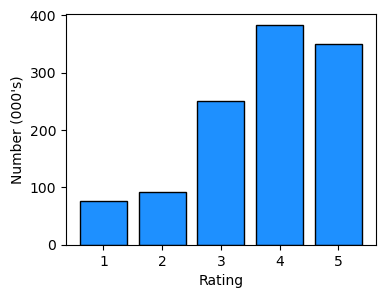

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
plt.bar([1,2,3,4,5], height=rating_counts, width=0.8, color='dodgerblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Number (000\'s)')
plt.show()

In [46]:
summary_df = new_df.describe()
summary_df = summary_df.drop(['count','min','25%','50%','75%','max'])
summary_df = summary_df.drop('rating', axis=1)
summary_df

,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values
mean,3.572287,3.512575,3.276769,3.606365,3.706826
std,1.228475,1.190497,1.327884,1.266644,1.283367


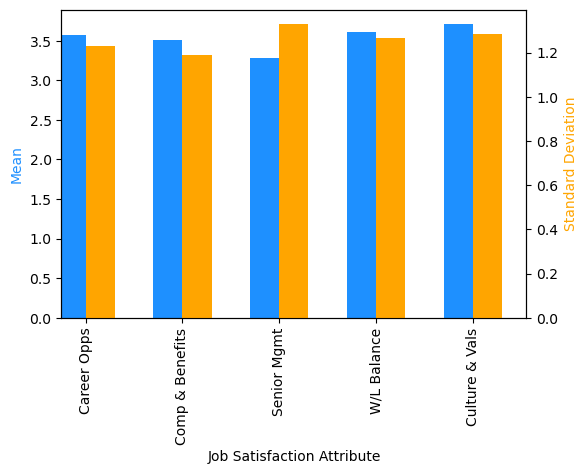

In [47]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)
ax2 = ax.twinx()

summary_df.loc['mean'].plot(kind='bar', color='dodgerblue', ax=ax, width=0.3, position=1)
summary_df.loc['std'].plot(kind='bar', color='orange', ax=ax2, width=0.3, position=0)

ax.set_xlabel('Job Satisfaction Attribute')
ax.set_xticklabels(labels = ['Career Opps','Comp & Benefits','Senior Mgmt','W/L Balance','Culture & Vals'])
ax.set_ylabel('Mean')
ax.yaxis.label.set_color('dodgerblue')
ax2.yaxis.label.set_color('orange')
ax2.set_ylabel('Standard Deviation')

plt.show()

In [48]:
print(comp_counts)
over_30k = comp_counts.copy()
over_30k = over_30k[over_30k > 30000]
print(over_30k)

firm
amazon                            121747
oracle                             65660
cognizant technology solutions     64066
accenture                          56224
hp inc                             51109
                                   ...  
global payment technologies            2
aehr test systems                      2
nexon automation                       2
compro systems                         1
proto labs                             1
Name: count, Length: 310, dtype: int64
firm
amazon                            121747
oracle                             65660
cognizant technology solutions     64066
accenture                          56224
hp inc                             51109
infosys                            43579
ibm                                42191
hcltech                            37988
wipro                              36960
Name: count, dtype: int64


In [49]:
over_30k = over_30k.apply(lambda x: x/1000)
print(over_30k.index)
over_30k = over_30k.set_axis(['Amazon','Oracle','Cognizant','Accenture','HP','InfoSys','IBM','HCLTech','WiPro'])
print(over_30k.index)

Index(['amazon', 'oracle', 'cognizant technology solutions', 'accenture',
       'hp inc', 'infosys', 'ibm', 'hcltech', 'wipro'],
      dtype='object', name='firm')
Index(['Amazon', 'Oracle', 'Cognizant', 'Accenture', 'HP', 'InfoSys', 'IBM',
       'HCLTech', 'WiPro'],
      dtype='object')


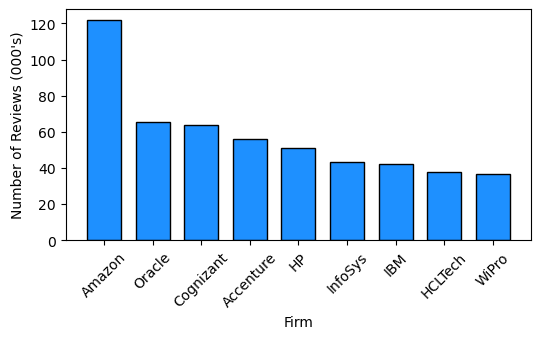

In [50]:
plt.figure(figsize=(6,3))
plt.bar(over_30k.index.to_list(), height=over_30k, width=0.7, color='dodgerblue', edgecolor='black')
plt.xlabel('Firm')
plt.xticks(rotation=45)
plt.ylabel('Number of Reviews (000\'s)')
plt.show()

# Something to consider here: is amazon really a tech company? Are most of the reviews about the delivery company rather than the tech side of things? Worth considering, since this may skew your results quite significantly.

## Step 3: Retrieve Yahoo Finance data on company financials

Great, now the next step is to retrieve financials for each company. First we have to decide which financial data to use. We have a number of options:

In [51]:
financials = ['industry']

In [52]:
import yfinance as yf
import requests

stock = yf.Ticker('AAPL')
for key in stock.info.keys():
    print(key)

address1
city
state
zip
country
phone
website
industry
industryKey
industryDisp
sector
sectorKey
sectorDisp
longBusinessSummary
fullTimeEmployees
companyOfficers
auditRisk
boardRisk
compensationRisk
shareHolderRightsRisk
overallRisk
governanceEpochDate
compensationAsOfEpochDate
irWebsite
maxAge
priceHint
previousClose
open
dayLow
dayHigh
regularMarketPreviousClose
regularMarketOpen
regularMarketDayLow
regularMarketDayHigh
dividendRate
dividendYield
exDividendDate
payoutRatio
fiveYearAvgDividendYield
beta
trailingPE
forwardPE
volume
regularMarketVolume
averageVolume
averageVolume10days
averageDailyVolume10Day
bid
ask
bidSize
askSize
marketCap
fiftyTwoWeekLow
fiftyTwoWeekHigh
priceToSalesTrailing12Months
fiftyDayAverage
twoHundredDayAverage
trailingAnnualDividendRate
trailingAnnualDividendYield
currency
enterpriseValue
profitMargins
floatShares
sharesOutstanding
sharesShort
sharesShortPriorMonth
sharesShortPreviousMonthDate
dateShortInterest
sharesPercentSharesOut
heldPercentInsiders
hel

Some good options:

In [62]:
financials = ['overallRisk','fiftyDayAverage','dividendYield','beta','trailingPE','trailingEps','marketCap','enterpriseValue','profitMargins', 'bookValue','earningsQuarterlyGrowth','ebitda','totalRevenue','revenuePerShare','returnOnEquity','earningsGrowth','revenueGrowth']

print(f"{stock.info['shortName']} ({stock.info['symbol']})")
for financial in financials:
    print(f"{financial}: {stock.info[financial]}")

Apple Inc. (AAPL)
overallRisk: 1
fiftyDayAverage: 213.7706
dividendYield: 0.0047999998
beta: 1.244
trailingPE: 31.936073
trailingEps: 6.57
marketCap: 3190124445696
enterpriseValue: 3230243225600
profitMargins: 0.26441
bookValue: 4.382
earningsQuarterlyGrowth: 0.079
ebitda: 131781001216
totalRevenue: 385603010560
revenuePerShare: 24.957
returnOnEquity: 1.60583
earningsGrowth: 0.111
revenueGrowth: 0.049


Seeing if I can get AAPL's EPS in Q1 2018 as an example:

In [67]:
stock = yf.Ticker('AAPL')
stock.financials

,2023-09-30,2022-09-30,2021-09-30,2020-09-30
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0
Tax Rate For Calcs,0.147,0.162,0.133,0.144
Normalized EBITDA,129188000000.0,133138000000.0,123136000000.0,81020000000.0
Net Income From Continuing Operation Net Minority Interest,96995000000.0,99803000000.0,94680000000.0,57411000000.0
Reconciled Depreciation,11519000000.0,11104000000.0,11284000000.0,11056000000.0
Reconciled Cost Of Revenue,214137000000.0,223546000000.0,212981000000.0,169559000000.0
EBITDA,129188000000.0,133138000000.0,123136000000.0,81020000000.0
EBIT,117669000000.0,122034000000.0,111852000000.0,69964000000.0
Net Interest Income,-183000000.0,-106000000.0,198000000.0,890000000.0
Interest Expense,3933000000.0,2931000000.0,2645000000.0,2873000000.0


In [71]:
stock.quarterly_income_stmt

,2024-03-31,2023-12-31,2023-09-30,2023-06-30,2023-03-31,2022-12-31
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0,0.0,NaN
Tax Rate For Calcs,0.158,0.159,0.149715,0.125,0.149,NaN
Normalized EBITDA,30736000000.0,43221000000.0,30653000000.0,26783000000.0,31216000000.0,NaN
Net Income From Continuing Operation Net Minority Interest,23636000000.0,33916000000.0,22956000000.0,19881000000.0,24160000000.0,NaN
Reconciled Depreciation,2836000000.0,2848000000.0,2653000000.0,3052000000.0,2898000000.0,NaN
Reconciled Cost Of Revenue,48482000000.0,64720000000.0,49071000000.0,45384000000.0,52860000000.0,NaN
EBITDA,30736000000.0,43221000000.0,30653000000.0,26783000000.0,31216000000.0,NaN
EBIT,27900000000.0,40373000000.0,28000000000.0,23731000000.0,28318000000.0,NaN
Net Interest Income,NaN,NaN,-18000000.0,-18000000.0,-12000000.0,-135000000.0
Interest Expense,NaN,NaN,1002000000.0,998000000.0,930000000.0,1003000000.0


In [108]:
samsung = yf.Ticker('005930.KS')
samsung.get_earnings_dates(limit=20)

,EPS Estimate,Reported EPS,Surprise(%)
Earnings Date,,,
2025-07-29 19:00:00+09:00,NaN,NaN,NaN
2025-04-28 19:00:00+09:00,NaN,NaN,NaN
2025-01-29 19:00:00+09:00,NaN,NaN,NaN
2024-10-29 19:00:00+09:00,NaN,NaN,NaN
2024-07-31 19:00:00+09:00,1255.02,NaN,NaN
2024-07-31 08:00:00+09:00,1255.02,1419.0,0.1307
2024-04-30 19:00:00+09:00,790.95,975.0,0.2327
2024-04-30 08:00:00+09:00,790.95,975.0,0.2327
2024-01-31 08:00:00+09:00,407.77,887.0,1.1753


In [118]:
samsung.get_cash_flow(pretty=True, freq='quarterly')

,2023-12-31,2023-09-30,2023-06-30,2023-03-31,2022-12-31
Free Cash Flow,4057593000000.0,-3921732000000.0,-8510566000000.0,-8022035000000.0,1146955000000.0
Repayment Of Debt,354993000000.0,472808000000.0,-1010736000000.0,-1036644000000.0,-2379495000000.0
Issuance Of Debt,2265657000000.0,41176000000.0,135243000000.0,58036000000.0,128526000000.0
Capital Expenditure,-15887636000000.0,-13652241000000.0,-16680481000000.0,-14313809000000.0,-17465945000000.0
End Cash Position,69080893000000.0,75144284000000.0,79919775000000.0,72949377000000.0,49680710000000.0
Beginning Cash Position,75144284000000.0,79919775000000.0,72949377000000.0,49680710000000.0,44515421000000.0
Effect Of Exchange Rate Changes,-1597742000000.0,874995000000.0,30310000000.0,1485222000000.0,-5092340000000.0
Changes In Cash,-4465649000000.0,-5650486000000.0,6940088000000.0,21783445000000.0,10257629000000.0
Financing Cash Flow,125378000000.0,-1957717000000.0,-5780921000000.0,-979799000000.0,-4705294000000.0
Net Other Financing Charges,72000000.0,-8363000000.0,121000000.0,-948000000.0,797000000.0


SO after a bunch of research and testing it turns out yfinance can't get historical financials, only the 4 or 5 most recent ones. So we have a couple options on how to proceed from here.

### Option 1

We use what we have. We have historical EPS and historical share prices for basically all dates. Of note: stock splits don't affect the stock price data.

### Option 2

We can also consider just using the last 4 years of financials and reviews. From testing it would cut our dataset size by around 60%, and we'd only be able to use yearly performance metrics which would be a fair bit less correlated than quarterly metrics. Meh.

### Option 3

Try to find some other source of financial performance metrics. Compustat seems too difficult to get, and most other services seem to cost a lotta money. Not ideal.

#### Looks like we might be in luck. I'm applying to the WRDS as we speak and waiting for approval from USYD. Once I get that, I'll have access to the full database. That should provide me with a tonne of financial metrics and more. Now, we wait!



Out of the three options, I'm liking Option 1 the most. The reason I'm hesitant with it is because stock prices are affected so heavily by market forces that I suspect it'd make my analysis useless. I'm trying to consider this a little bit. Theoretically if the average review rating doesn't change at all over the lifetime of a company, but the price does change a lot with market forces, then that'd make the linear regression pretty much useless. EPS though would be a much better measure.





If you use historical EPS, be aware of tickers ending in .KS and .T which you may have to divide EPS by 100. To fix, get the most recent EPS of all companies, sort by value and then have a look at like the top 50 and see what needs to be done.

In [148]:
stock.splits

Date
1987-06-16 00:00:00-04:00    2.0
2000-06-21 00:00:00-04:00    2.0
2005-02-28 00:00:00-05:00    2.0
2014-06-09 00:00:00-04:00    7.0
2020-08-31 00:00:00-04:00    4.0
Name: Stock Splits, dtype: float64

In [152]:
stock.dividends

Date
1987-05-11 00:00:00-04:00    0.000536
1987-08-10 00:00:00-04:00    0.000536
1987-11-17 00:00:00-05:00    0.000714
1988-02-12 00:00:00-05:00    0.000714
1988-05-16 00:00:00-04:00    0.000714
                               ...   
2023-05-12 00:00:00-04:00    0.240000
2023-08-11 00:00:00-04:00    0.240000
2023-11-10 00:00:00-05:00    0.240000
2024-02-09 00:00:00-05:00    0.240000
2024-05-10 00:00:00-04:00    0.250000
Name: Dividends, Length: 83, dtype: float64

In [163]:
avgo = yf.Ticker('AVGO')
print(avgo.history(interval="3mo", start="2018-01-01", end="2024-08-01"))

                                 Open        High         Low       Close  \
Date                                                                        
2018-01-01 00:00:00-05:00   20.867686   22.031689   18.066531   18.930094   
2018-04-01 00:00:00-04:00   19.068913   22.154824   18.093256   19.777222   
2018-07-01 00:00:00-04:00   19.831800   20.799064   16.310497   20.380274   
2018-10-01 00:00:00-04:00   20.628993   21.769963   17.329253   21.161612   
2019-01-01 00:00:00-05:00   20.927951   25.507123   19.370445   25.289307   
2019-04-01 00:00:00-04:00   25.718847   27.423480   21.220106   24.424885   
2019-07-01 00:00:00-04:00   25.842930   26.191581   22.486639   23.649092   
2019-10-01 00:00:00-04:00   24.056900   28.632786   23.101610   27.320450   
2020-01-01 00:00:00-05:00   27.885367   28.956002   13.594248   20.705313   
2020-04-01 00:00:00-04:00   20.248186   29.140018   19.510161   28.029871   
2020-07-01 00:00:00-04:00   28.273781   34.002831   27.293068   32.689232   

## Important: Yahoo returns maximum 4 years or 5 quarters, regardless of start_date.

# Note: stopping programming here because I have everything I need to write the Progress Report - we have plenty of Preliminary Results in regards to the total dataset we have. Lots to talk about. Continue on after the report is complete.

YFinance allows for 8000 GET requests per day, which is more than enough for our 318 companies. Let's check that YFinance actually has data for all of our tickers.

In [54]:
ticker_infos = []
for ticker in tickers_df['Ticker']:
    ticker_info = yf.Ticker(ticker)
    ticker_infos.append(ticker_info)

In [61]:
print(ticker_infos[300].info)

{'address1': '177 Huntington Avenue', 'address2': 'Suite 1703 PMB 73480', 'city': 'Boston', 'state': 'MA', 'zip': '02115', 'country': 'United States', 'phone': '978 897 0100', 'website': 'https://www.seachange.com', 'industry': 'Software - Application', 'industryKey': 'software-application', 'industryDisp': 'Software - Application', 'sector': 'Technology', 'sectorKey': 'technology', 'sectorDisp': 'Technology', 'longBusinessSummary': "SeaChange International, Inc. provides video delivery, advertising, streaming platforms, and emerging Free Ad-Supported Streaming TV (FAST) products and services that facilitate the aggregation, licensing, management and distribution of video and advertising content worldwide. It offers Operator TV Platform solutions including customer's current network with OTT video management solutions in a single deployment, digital video broadcasting - cable / quadrature amplitude modulation networks with OTT streaming, and immersive multiscreen experience and on dema

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## TO-DO:

1. Find an adequate csv online of the top ~500 tech companies that allows you to match company name with company ticker - companiesmarket cap csv in thesis folder is a good start. Think of if you want to combine multiple csvs, such as top 500 software companies too. Some good ideas:
https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/?page=2
https://companiesmarketcap.com/software/largest-software-companies-by-market-cap/?page=2/
https://stackoverflow.com/questions/5246843/how-to-get-a-complete-list-of-ticker-symbols-from-yahoo-finance
https://www.nasdaq.com/market-activity/stocks/screener -- this looks great
2. Figure out how to match company name to ticker, such as through a fuzzy search. Look at this for inspiration:
https://towardsdatascience.com/using-word-embeddings-to-identify-company-names-and-stock-tickers-f194e3648a66
https://medium.com/dnb-data-science-hub/company-name-matching-6a6330710334
https://financeapi.net/dashboard -- this is limited to 100 company searches per day, which I
3. Work out discrepancies such as the Applebees example above. This may have to be manual, which shouldn't be an issue given that you have only 500 companies. This step may be linked to step 2 anyways. 
3. Find source of financial data to get basic stats such as EPS, Revenue or Growth, using the ticker. Theoretically we can actually just do this with yfinance now that we have tickers. Have a look at compustat too. Otherwise we can try combining with other datasets, such as:
https://wrds-www.wharton.upenn.edu/pages/grid-items/compustat-global-wrds-basics/
https://finance.yahoo.com/quote/%5ENDXT/components/
https://www.tradingview.com/symbols/NASDAQ-NDXT/components/
https://medium.com/@kasperjuunge/yfinance-10-ways-to-get-stock-data-with-python-6677f49e8282


## Step 3: Exploratory data analysis

In [56]:
print(new_df.info())



# print(stock.get_shares_full(start="2022-01-01"))
# print(stock.get_financials())

<class 'pandas.core.frame.DataFrame'>
Index: 1152488 entries, 0 to 1152492
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   rating                     1152488 non-null  float64
 1   title                      1152488 non-null  object 
 2   status                     1152488 non-null  object 
 3   pros                       1152488 non-null  object 
 4   cons                       1152488 non-null  object 
 5   Recommend                  1152488 non-null  object 
 6   CEO Approval               1152488 non-null  object 
 7   Business Outlook           1152488 non-null  object 
 8   Career Opportunities       1152488 non-null  float64
 9   Compensation and Benefits  1152488 non-null  float64
 10  Senior Management          1152488 non-null  float64
 11  Work/Life Balance          1152488 non-null  float64
 12  Culture & Values           1152488 non-null  float64
 13  firm             

In [57]:
new_df.head(5)

,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm,date,job,Ticker
0,5.0,It was a good culture,Former Employee,- work from home -good culture -great benefits,-some managers shouldn't be managers,v,v,r,5.0,5.0,5.0,5.0,5.0,microsoft,"Mar 24, 2023",Customer Success Manager (CSM),MSFT
1,5.0,Always-changing career and technology opportun...,"Current Employee, more than 10 years",Easy to make an impact on many people around t...,Extreme bureaucracy: random never-ending compl...,v,v,v,5.0,4.0,5.0,5.0,5.0,microsoft,"Mar 19, 2023",Principal Program Manager Lead,MSFT
2,3.0,Does not deserve the reputation of good cultur...,"Former Employee, more than 5 years","1. If you have a good manager, definitely your...","1. If your manager is not good, then your life...",x,x,x,3.0,4.0,1.0,2.0,1.0,microsoft,"Mar 16, 2023",Software Engineer II,MSFT
3,4.0,Great company to work in,"Current Employee, more than 1 year",. Nice Pay . WFH first culture . Great office ...,. Recent layoffs across the company shocked ma...,v,v,v,5.0,5.0,4.0,4.0,5.0,microsoft,"Mar 23, 2023",Software Engineer,MSFT
4,5.0,Amazing culture,"Former Employee, more than 1 year",Their work culture is amazing! People are supe...,Higher-up leadership members may happen to not...,v,v,v,5.0,5.0,4.0,5.0,5.0,microsoft,"Mar 21, 2023",Customer Advisor,MSFT


## Step 4: Data cleaning and feature transformation

## Step 5: Combine datasets